# List-based Simulations 

Every GRANAD simulation dependens on orbitals and their interactions. To make orbitals interact and spatially displace them, you need to put them into list, which is what this tutorial is about.

## Orbitals: A Recap

As already explained in the "Getting Started" Tutorial, Orbitals are the basic building blocks of orbital lists. They are book keeping devices containing quantum numbers, position and a user-defined string. 

## Orbital lists

We can make orbitals interact by putting them into a list. The class we need for this is called `OrbitalList` It allows us to

1. couple orbitals 
2. set simulation parameters
3. compute and plot physical observables (such as energy spectra or time-domain simulations)

## Coupling orbitals

We already learned in the first tutorial that there are two ways of making an orbital list:

1. creating it
2. cutting it from a bulk material

In the former case, we have to specify all couplings ourselves. In the latter case, this information is extracted from the material.

Say we want to specify an isolated atom representing a quantum optical two-level system (TLS). We will create two orbitals with two energy levels that belong to the same atom.

In [1]:
from granad import Orbital
lower_level = Orbital(tag="atom")
upper_level = Orbital(tag="atom")

To use the Orbitals in a simulation, we group them into a list

In [2]:
from granad import OrbitalList
atom = OrbitalList([lower_level, upper_level])
print(atom)

List with 2 orbitals, 2 electrons.
Excitation: [0] electrons excited from energy levels [0] to [0].
Included tags with number of orbitals: {'atom': 2}


We can tell that the total electron number in our system is 2, since by default GRANAD considers each orbital to contribute 1 electron. This can be changed as follows

In [3]:
atom.set_electrons(1)
print(atom)

List with 2 orbitals, 1 electrons.
Excitation: [0] electrons excited from energy levels [0] to [0].
Included tags with number of orbitals: {'atom': 2}


We can compute static quantities of the atom, like its energies. By default, GRANAD considers all couplings to be zero unless stated otherwise. 

In [4]:
print(atom.energies)

[0. 0.]


As no couplings are specified, only zero energies are obtained. 

GRANAD lets us explicitly set elements of the Hamiltonian and Coulomb matrices by their list indices. We have put the Orbital called `lower_level` in the 0-th position, so we can assign it an an energy of -0.5. 

In [5]:
atom.set_hamiltonian_element( 0, 0, -0.5)

Similarly, we can assign the energy to the upper level

In [6]:
atom.set_hamiltonian_element( 1, 1, 0.5)

If we now check the energies, we see that they have updated automatically

In [7]:
print(atom.energies)

[-0.5  0.5]


You might have realized that you didn't have to call any function to get the energies with the updated couplings. This is because GRANAD evaluates lazily:  physical quantities that depend on the couplings (like the energies or a Coulomb matrix entry) will be computed when they are needed. Aside from using list indices for setting couplings, you can also use the orbitals themselves. This takes some time to get used to, but is quite practical.

For illustration, we couple the upper and lower level. This could be achieved as follows

In [8]:
atom.set_hamiltonian_element( 1, 0, 0.5j)

Or like this

In [9]:
atom.set_hamiltonian_element( upper_level, lower_level, 0.1j) # changes the same element 
print(atom.hamiltonian)

[[-0.5-0.j   0. +0.1j]
 [ 0. -0.1j  0.5-0.j ]]


Setting Coulomb matrix elements proceeds analogously by calling `atom.set_coulomb_element`.

We see that the matrix entry corresponding to the inter-level coupling is now modified accordingly, with hermiticity of the Hamiltonian taken into account properly.

Introducing dipole transitions works similarly: We  have to remember to pass in a vector for the transition

In [10]:
atom.set_dipole_element( upper_level, lower_level, [0,0,1] ) # transition dipole oriented in z-direction
print(atom.dipole_operator[2])

[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]


Let's look at the position of the atom

In [11]:
print(atom.positions)

[[0. 0. 0.]
 [0. 0. 0.]]


It is located at the origin. Let's shift it. We can manipulate the "position" attribute of the two orbitals by hand (not recommended) or we can use the tag we have defined, like so

In [12]:
atom.shift_by_vector( [0, 0, 1] )
print(atom.positions)

[[0. 0. 1.]
 [0. 0. 1.]]


Every orbital we have annotated by this tag will be shifted. 

Consider a slightly more involved geometric example, i.e. stacking two graphene flakes.

We choose rectangles

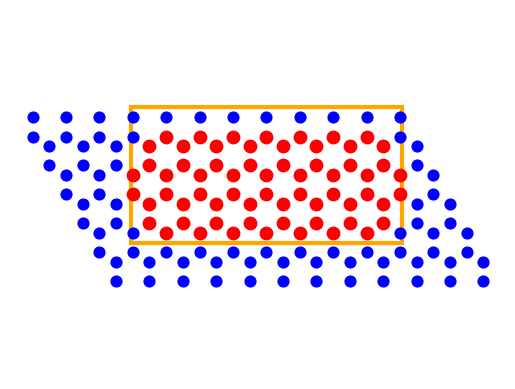

In [13]:
from granad import MaterialCatalog, Rectangle
flake = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10), plot = True )

By default, graphene flakes are created in the xy - plane. They contain pz Orbitals which are grouped together by an id. You can directly apply shifts to groups of orbitals. We want to shift the entire flake

In [14]:
flake.shift_by_vector( [0,0,1]  )
print(flake.positions)

[[-7.38       -4.26084499  1.        ]
 [-8.61       -2.13042249  1.        ]
 [-9.84        0.          1.        ]
 [-4.92       -4.26084499  1.        ]
 [-6.15       -2.13042249  1.        ]
 [-7.38        0.          1.        ]
 [-8.61        2.13042249  1.        ]
 [-2.46       -4.26084499  1.        ]
 [-3.69       -2.13042249  1.        ]
 [-4.92        0.          1.        ]
 [-6.15        2.13042249  1.        ]
 [ 0.         -4.26084499  1.        ]
 [-1.23       -2.13042249  1.        ]
 [-2.46        0.          1.        ]
 [-3.69        2.13042249  1.        ]
 [ 2.46       -4.26084499  1.        ]
 [ 1.23       -2.13042249  1.        ]
 [ 0.          0.          1.        ]
 [-1.23        2.13042249  1.        ]
 [ 4.92       -4.26084499  1.        ]
 [ 3.69       -2.13042249  1.        ]
 [ 2.46        0.          1.        ]
 [ 1.23        2.13042249  1.        ]
 [ 7.38       -4.26084499  1.        ]
 [ 6.15       -2.13042249  1.        ]
 [ 4.92        0.        

Now we have shifted the entire flake. But we actually wanted a stack, so we need a new flake at the bottom.

In [15]:
second_flake = MaterialCatalog.get("graphene").cut_flake( Rectangle(10, 10) )

How do we combine the flakes? Well, both are lists, so we can  add them

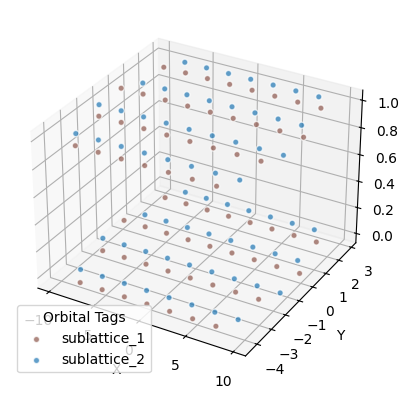

In [16]:
stack = flake + second_flake
stack.show_3d()

This is the first step. Now, we need to set couplings. For simplicity, we will couple nearest neighbors in different layers by setting their hopping rate in the Hamiltonian to 2.0. Interlayer nearest neighbors are separated by a distance of 1 Angström.

To achieve this, we could

1. loop over all orbitals in the lower flake.
2. get their nearest neighbor in the upper flake.
3. call stack.set_hamiltonian_element to set the coupling to 1.0.

This is very cumbersome, so we take a more flexible approach: specifying the coupling by a function dependent on the distance vector. We want a function that is 2.0 for a distance of 1.0 and 0.0 else. One way to express this is a narrow gaussian around 1.0.

In [17]:
import jax.numpy as jnp
def interlayer_hopping( distance ):
    return 2.0 * jnp.exp( -100*(jnp.linalg.norm(distance) - 1.0)**2 )

To set the coupling, we do

In [18]:
stack.set_hamiltonian_groups( flake, second_flake, interlayer_hopping )

We can perform a slightly more interesting simulation by looping over a bunch of nearest-neighbor couplings and study the impact on the energy landscape. To this end, we rewrite the coupling function: 

In [19]:
def interlayer_hopping_factory( coupling ):
    def interlayer_hopping( distance ):
        return coupling * jnp.exp( -100*(jnp.linalg.norm(distance) - 1.0)**2 )    
    return interlayer_hopping

We now loop and plot

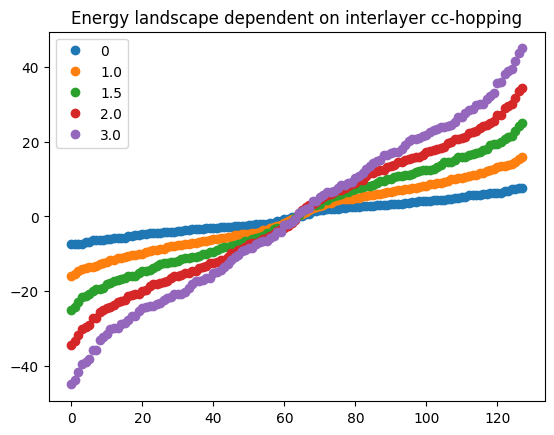

In [20]:
import matplotlib.pyplot as plt
n_orbs = len(stack)
for coupling in [0, 1.0, 1.5, 2.0, 3.0]:
    interlayer_hopping = interlayer_hopping_factory( coupling )
    stack.set_hamiltonian_groups( flake, second_flake, interlayer_hopping )    
    plt.plot( stack.energies, 'o', label = coupling )
plt.title("Energy landscape dependent on interlayer cc-hopping")
plt.legend()
plt.show()

Admittedly, this way of specifying couplings gets some time to get used to, but it is really flexible. 

To recap: we have learned that there are three different ways to address orbitals in a list, corresponding to varying levels of granularity:

1. *Single Orbitals* may be accessed by their list index or directly.
2. *User-grouped Orbitals* may be accessed by their tag.
3. *Auto-grouped Orbitals* may be accessed by their group_id.

Based on this information, you can manipulate orbitals, e.g. shift them around.

## Pitfalls

Deleting and modifying state is dangerous.

In [21]:
atom = OrbitalList( [Orbital(), Orbital()] )
atom.set_electrons(1)
del atom[0] # ALWAYS removes 1 electron
print(atom.electrons) # you have an empty atom

0


For this reason, the deletion (and append) operation on the orbital list may change or be removed entirely, meaning it wont be possible to add single orbitals or remove them from the structure. A likely and less dangerous replacement would be immutable, copyable data structures.